<center>
<img src="logo.png" height="900"> 
</center>


# Модель с нулевым раздутием (Zero inflated model)

__Это задание является бонусным.__ Вы можете его не решать, это никак не повлияет на оценку за курс. 

Метод максимального правдоподобия позволяет нам оценивать не только классические модели вроде линейной или логистической регрессии. Он позволяет нам специфицировать произвольную модель, которая на наш взгляд подходит для данных. Именно такую модель в этом, бонусном, упражнении мы с вами и оценим.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

Иногда так бывает, что в той переменной, которую мы собираемся прогнозировать, встречается очень много нулей. Представим себе, что биологи хотят смоделировать, сколько рыбы ловят отдахающие в национальном парке, когда выезжают туда с палатками. Понятное дело, что подавляющее большинство не будет ловить рыбу. Из-за этого в данных будет довольно много нулей. 

## Описание данных 

В парке отдыхало $250$ групп туристов. Каждой группе был задан вопрос о том, сколько рыбы они поймали `count`. В каждой группе посчитали число детей `child`, число людей `persons`. Каждой группе отдыхающих задавали вопрос: приехали ли они с палатками `camper`. 

Колонки с координатами и информацией о ловле на живца нас интересовать не будут. Их мы удалим. 

In [2]:
df = pd.read_csv("fish.tsv", sep='\t')
df.drop(['xb', 'zg', 'livebait'], axis=1, inplace=True)
df.head()

,nofish,camper,persons,child,count
0,1,0,1,0,0
1,0,1,1,0,0
2,0,0,1,0,0
3,0,1,2,1,0
4,0,0,1,0,1


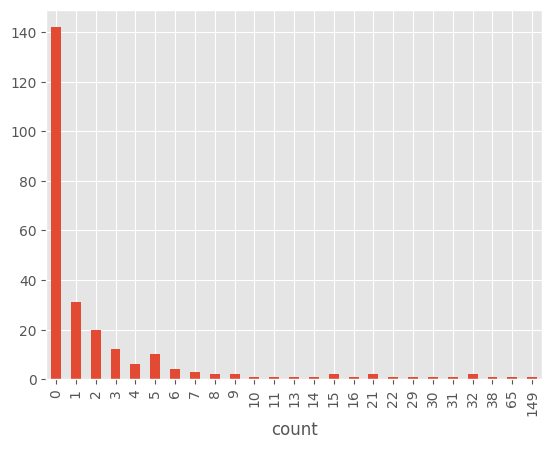

In [3]:
df['count'].value_counts().sort_index(ascending=True).plot(kind='bar');

Видно, что в данных о пойманной рыбе нули встречаются чаще всего. Специфичные данные требуют специфичных моделей. Будем предполагать, что:

- Число пойманной рыбы имеет распределение Пуассона 
- Вероятность того, что группа туристов не поймала ни одной рыбы моделируется отдельно

----------------

__а)__ Предпримем первую попытку построить [zero inflated model.](https://en.wikipedia.org/wiki/Zero-inflated_model) Этот пункт решён за вас. Разберитесь в том, как именно мы выводим модель.

__Цель:__ вытащить нулевое значение и вероятность для него в отдельный параметр. 

__Делай раз:__  мы хотим, чтобы распределение Пуассона для нас работало, начиная с $X = 1$. В таком случае нам его надо сдвинуть вправо так, чтобы сумма вероятностей по-прежнему оставалась равна единице. Мы знаем, что 

$$
\sum_{k=0}^{\infty} P(X = k) = \sum_{k=0}^{\infty} \frac{\lambda^k e^{-\lambda}}{k!} = e^{-\lambda} + \sum_{k=1}^{\infty} \frac{\lambda^k e^{-\lambda}}{k!} = 1.
$$

Если мы решим оставить только сумму, начиная с единицы, получится, что 

$$
\sum_{k=1}^{\infty} \frac{\lambda^k e^{-\lambda}}{k!} = 1 - e^{-\lambda}.
$$

Чтобы перед нами было полноценное распределение и все вероятности в сумме давали $1$, нам надо поделить сумму слева на $1 - e^{-\lambda}$. Получается, что для распределения Пуассона, обрезанного со стороны нуля, формула для поиска вероятности выглядить как 

$$
P(X = k \mid X > 0) = \frac{1}{1 - e^{-\lambda}} \cdot \frac{\lambda^k e^{-\lambda}}{k!}.
$$

Можно получить эту формулу исходя не из интуции, а из формулы условной вероятности:

$$
P(X = k \mid X > 0) = \frac{P(X = k \cap X > 0)}{P(X > 0)} = \frac{\frac{\lambda^k e^{-\lambda}}{k!}}{1 - e^{-\lambda}}
$$


__Делай два:__ Теперь давайте построим смесь из двух распределений. Случайная величина $X$ будет принимать с вероятностью $p$ значение $0$, и с вероятностью $1 - p$ будет распределена по Пуассону со сдвигом: 

$$
\begin{aligned}
& P(X = 0) = p \\
& P(X = k) = (1 - p) \cdot \frac{1}{1 - e^{-\lambda}} \cdot \frac{\lambda^k e^{-\lambda}}{k!}.
\end{aligned}
$$

Построенная модель — это ещё не совсем то, что нам надо. У такой формулировки модели есть минус. Невозможно проверить гипотезу о том, что в нуле нет никаких особенностей. Если $p = 0$, то у нас просто-напросто не бывает нулевых значений, а нам надо при $p=0$ получить обычное распределение Пуассона. 

__Итоговая модель:__ Хочется, чтобы у нас была возможность протестировать такую гипотезу. Для этого ноль выносится в отдельную категорию не в результате обрезания распределения Пуассона, а немного иначе.  

Давайте домножим $P(X = k)$ на $(1-p)$, а потом просто вынесем $(1 - p) \cdot P(X = 0)$ в отдельное слагаемое. И тогда получится модель: 

$$
\begin{aligned}
& P(X = 0) = p + (1 - p) \cdot e^{-\lambda} \\
& P(X = k) = (1 - p) \cdot \frac{\lambda^k e^{-\lambda}}{k!}.
\end{aligned}
$$ 

Если $p=0$, то у нас получается распределение Пуассона. У нас возникает возможность проверить гипотезу $H_0$, состояшую в том, что в нуле нет никакого особого значения. Распределение Пуассона оказывается вложено в нашу более сложную модель в лучших традициях частотной статистики. 

----------------

__б)__ Выпишите на бумажке логарифмическую функцию правдоподобия для Zero Inflated Model. Вбейте её в python.

__Hint:__ Множителем $\frac{1}{y_1! \cdot \ldots \cdot y_n!}$ нужно пренебречь. Он не влияет на оптимизацию функции. Очень удобно будет выписать функцию правдоподобия для одного наблюдения, а затем аккуратно усложнять её в следующих пунктах. Векторный `numpy` позволит удобно с ней работать. 

In [ ]:
from scipy.special import factorial
def lnL(theta, data):
    
    p = np.exp(theta[0]) / (1 + np.exp(theta[0]))  
    lam = np.exp(theta[1]) 
    
    y = data['count'].to_numpy()
    
    log_likelihood_zero = np.log(p + (1 - p) * np.exp(-lam))
    
    log_likelihood_nonzero = (
        np.log(1 - p) + y * np.log(lam) - lam - np.log(factorial(y))
    )
    
    # Общий логарифм правдоподобия
    log_likelihood = np.where(
        y == 0, 
        log_likelihood_zero, 
        log_likelihood_nonzero
    )
    
    return log_likelihood.sum()



In [16]:
lnL([1,1], df)

-1458.9921824887233

In [ ]:


assert np.abs(lnL([0.2, 0.2], df) - 107.543) < 1e-4
assert np.abs(lnL([0, 0], df) - 236.8036) < 1e-4
assert np.abs(lnL([1,1], df) - -347.5161) < 1e-4

AssertionError: 

__в)__ Оцените для случайной величины $Y$ (число пойманной рыбы) параметры $p$ и $\lambda$ методом максимального правдоподобия. 

In [ ]:
from scipy.optimize import minimize
theta_init = [0, 1]

res = minimize(lnL, theta_init, args=(df,))
print("Estimated parameters:", res.x)

p_hat = np.exp(res.x[0]) / (1 + np.exp(res.x[0]))
lambda_hat = np.exp(res.x[1])
print(f"p: {p_hat}, lambda: {lambda_hat}")

Estimated parameters: [  -16.76047335 -1033.10418437]
p: 5.260401445076485e-08, lambda: 0.0


C:\Users\ziiat\AppData\Local\Temp\ipykernel_11236\1546978878.py:14: RuntimeWarning: divide by zero encountered in log
  np.log(1 - p) + y * np.log(lam) - lam - np.log(factorial(y))
C:\Users\ziiat\AppData\Local\Temp\ipykernel_11236\1546978878.py:14: RuntimeWarning: invalid value encountered in multiply
  np.log(1 - p) + y * np.log(lam) - lam - np.log(factorial(y))
C:\Users\ziiat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\ziiat\AppData\Local\Temp\ipykernel_11236\1546978878.py:14: RuntimeWarning: divide by zero encountered in log
  np.log(1 - p) + y * np.log(lam) - lam - np.log(factorial(y))
C:\Users\ziiat\AppData\Local\Temp\ipykernel_11236\1546978878.py:14: RuntimeWarning: invalid value encountered in multiply
  np.log(1 - p) + y * np.log(lam) - lam - np.log(factorial(y))
C:\Users\ziiat\AppData\

In [20]:
# Задание бонусное - все тесты открытые :)
assert np.abs(res.fun + 679) < 1
assert np.abs(res.x[0] - 0.27) < 1e-2
assert np.abs(res.x[1] - 2.03) < 1e-2

AssertionError: 

Сравним получившееся значение $\hat{p}^{ML}$ с частотой нулей в данных. 

In [ ]:
np.mean(df['count'] == 0)

Совпало. Мы предположили выше, что $Y=0$ формируются независимо от остальной части, поэтому значение $p$ таким и получилось. Оценка $\hat{\lambda}^{ML}$ совпадет со средним, посчитанным по всем $y_i > 0$. 

In [ ]:
df['count'][df['count'] > 0].mean()

Для такой простой постановки можно решить задачу на листочке. Найдите оценки $\hat{\lambda}^{ML}$ и $\hat{p}^{ML}$ в явном виде.

__г)__ Проверьте с помощью теста отношения правдоподобий на уровне значимости $1\%$ гипотезу о том, что $p=0$. Если эта гипотеза не отвергается, то мы зря усложнили наше распределение. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def lnL_R(theta, data):
    p = 0
    lam = np.exp(theta)
    
# your code here


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

res_R =  ...
lnL_un = ...
lnL_r =  ...

LR_obs = ...
LR_cr = ...

# your code here


In [ ]:
# Задание бонусное - все тесты открытые :)
assert np.abs(lnL_r - -158.79) < 1e-2
assert np.abs(lnL_un - -679.48) < 1e-2
assert np.abs(LR_obs - 1041.38) < 1e-2
assert np.abs(LR_cr - 6.63) < 1e-2

__д)__ Поднимаем ставки. До этого мы смотрели на число пойманной рыбы как на отдельную случайную величину, которая ни от чего не зависит. Давайте усложним ситуацию. Пусть интенсивность пойманной рыбы объясняется другими факторами, то есть:

$$
\lambda_i =  \exp(\beta_0 + \beta_1 \cdot child_i + \beta_2 \cdot persons_i + \beta_3 \cdot camper_i).
$$

Это звучит логично, если у нас есть палатка, нас в группе много, то и рыбы мы будем ловить много. Экспонента здесь используется, чтобы параметр $\lambda_i$ всегда был положительным. 

Выпишите для такой модели логарифмическое правдоподобие, вбейте его в python и оцените параметры $\beta_0, \beta_1, \beta_2, \beta_3, p$. Удобнее всего будет вбивать его в матричном виде. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def lnL(theta, data):
    p = np.exp(theta[0])/(1 + np.exp(theta[0]))
    b = theta[1:]
    
# your code here


In [ ]:
par = np.hstack((0.5, np.ones(4)))
assert np.abs(lnL(par, df) - 27323.49) < 1e-2

In [ ]:
theta_init = np.hstack((0.5, np.ones(4)))
res = minimize(lnL, theta_init, args=df)
res

In [ ]:
assert np.abs(res.x[0] - -0.3658) < 1e-4
assert np.abs(res.x[-1] - 0.7956) < 1e-4

__е)__ Поднимаем ставки ещё выше. Скрестим нашу модель с логистической регрессией. Пусть не только интенсивность пуассоновского потока зависит от других факторов, но и вероятность не поймать ни одной рыбы: 

\begin{equation*}
\begin{aligned}
& z_i = \gamma_0 + \gamma_1 \cdot child_i + \gamma_2 \cdot persons_i + \gamma_3 \cdot camper_i \\
& p_i = P(y_i = 1 \mid child, persons, camper) = \frac{1}{1 + \exp(-z_i)} \\
\end{aligned}
\end{equation*}

Выпишите для такой модели логарифмическое правдоподобие, вбейте его в python и оцените параметры $\beta_0, \beta_1, \beta_2, \beta_3, \gamma_0, \gamma_1, \gamma_2, \gamma_3$.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def lnL(theta, data):
    beta = theta[:4]
    gamma = theta[4:]
    
# your code here


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you
theta_init = np.hstack((np.ones(4), np.ones(4)))
res = ...

# your code here


In [ ]:
assert np.abs(res.x[0] + 0.7982) < 1e-4
assert np.abs(res.x[-1] + 0.8336) < 1e-4

__ё)__ Ровно такие же результаты, как в пункте __е)__ можно получить с помощью уже реализованной в рамках пакета `statsmodels` модели. Код для этого написан ниже. 

In [ ]:
df['const'] = 1
y = df['count'].to_numpy()
X = df[['const', 'child', 'persons', 'camper']]

In [ ]:
import statsmodels.api as sm

model = sm.ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit').fit()
model.summary()

Сравните получившиеся результаты со своими и дайте ответ на следующие вопросы: 

- Все ли переменные значимы для прогнозирования интенсивности пуассоновского потока и $P(y_i = 0)?$  
- Проинтерпретируйте знаки перед коэффициентами, логично ли, что рост `persons` увеличивает интенсивность пуасоновского потока и уменьшает $P(y_i = 0)$? Логичные ли знаки стоит перед переменными `child` и `camper`?

Конечно же, с помощью такой модели можно попытаться спрогнозировать сколько рыбы поймает та или иная группа. Для этого надо посчитать все разумные $P(Y = k)$ и выбрать $k$, которое соотвествует максимальной. Более того, можно даже построить предиктивный интервал. Даже можно разбить выборку на тренировочную и тестовую, а дальше воспользоватся подходами из машинного обучения, чтобы сравнить нащу модель с классическими вариантами.